# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [71]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [72]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [73]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [74]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='moviereviews_train.tsv', my_random_seed=55)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [75]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 9997, 'Neg': 10003, 'TP': 5631, 'TN': 4753, 'FP': 5250, 'FN': 4366, 'Accuracy': 0.5192, 'Precision': 0.517507582023711, 'Recall': 0.5632689806942083, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [76]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 9997, 'Neg': 10003, 'TP': 9997, 'TN': 10003, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [77]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 9997, 'Neg': 10003, 'TP': 9997, 'TN': 10003, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [78]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 9997, 'Neg': 10003, 'TP': 9594, 'TN': 9837, 'FP': 166, 'FN': 403, 'Accuracy': 0.97155, 'Precision': 0.9829918032786885, 'Recall': 0.9596879063719116, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [79]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 9997, 'Neg': 10003, 'TP': 9997, 'TN': 10003, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [147]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=9.0)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 9997, 'Neg': 10003, 'TP': 9997, 'TN': 10003, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [148]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 9997, 'Neg': 10003, 'TP': 7695, 'TN': 7757, 'FP': 2246, 'FN': 2302, 'Accuracy': 0.7726, 'Precision': 0.7740669952721054, 'Recall': 0.7697309192757827, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

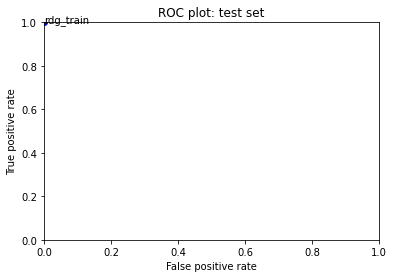

In [149]:
fits = [rdg_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [150]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [151]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
48
I am so appalled by this documentary. I am deeply embarrassed and ashamed by the way Puertoricans were portrayed. This documentary was not about the culture of Puertoricans. It was about the culture of Nuyoricans. Puertoricans and Nuyoricans are two different cultures. Very different cultures and should not be generalized to the Puerto Rican population. Rosie, before you make a documentary, you need to do the research. You also need to check and make sure your sources are credible. Puerto Ricans are not all loud and they do have class, which is one thing the documentary lacked to show. When I saw Rosie and Jimmie on the View and Rosie on Martha Stewart I was very excited about watching. I even made sure to let my parents know since they love Puerto Rico so much. After the first five minutes I could not believe how the documentary bashed the US and made Puerto Ricans look like a bunch of guinea pigs. You need to go and visit Puerto Rico and you will see t

3759
I had the distinct misfortune of catching up on two of 2004's worst films back to back this morning: first, the incoherent CGI-driven emptiness of The Chronicles of Riddick, and then, the embarrassing vanity project known as Greendale. One cost multimillions and the other cost pennies, but they're both bad. Really, really bad. <br /><br />Up front I should state I'm not the world's biggest Neil Young fan, but he has contributed his share of classic tunes: from Buffalo Springfield (whose best recordings were Young compositions) to Rust Never Sleeps, Harvest, and Mirror Ball, the man has penned some really great songs. Sadly, there are no great songs in Greendale, and precious few good ones, and the film around which they are built is truly cringeworthy and simplistic political sloganeering. Completely without merit as art and unimpressive as polemic, Greendale is best left forgotten. Buy the book if you feel compelled to contribute to Young's bank account.
* * * * * * * * * 
3867
A

7231
Much like Orson Welles thirty years earlier,Mike Sarne was given \the biggest train set in the world\"to play with,but unfortunately lacked the ability to do anything more than watch his train set become a train wreck that is still spoken of with shock and a strange sort of awe. Despite post - modern interpretations purporting somehow to see it as a gay or even feminist tract,the fact of the matter is that it was a major disaster in 1970 and remains one today.How anyone given the resources at Mr Sarne's disposal could have screwed up so royally remains a closely - guarded secret.Only Michael Cimino ever came close with the political and artistic Armageddon that constitutes \"Heaven's Gate\".Both films appeared to be ego trips for their respective directors but at least Mr Cimino had made one of the great movies of the 1970s before squandering the studio's largesse,whereas Mr Sarne had only the rather fey \"Joanna\" in his locker. Furthermore,\"Heaven's Gate\" could boast some memo

10658
I was one of quite a few extras in this big bomb. I just happened to be in the right place working safety for the race scenes at A.I.R. as it was know as back then.Thank goodness my scene in in the first few minutes of the movie and I don't have to sit through the whole thing. It was more of a big party than a movie set but hey, the pay was good.Attention to detail was not a strong point for this one, but who was going to know.The funny thing was seeing the cars in the track at the really slow speed and then in the movie speeded up to the what was close to normal speed.A lot of the scenes were changed as they were filmed I suppose to shave cost and time.But every one was having such a good time who cared!
* * * * * * * * * 
10772
Despite the excellent cast, this is an unremarkable film, especially from the aviation perspective. It may be somewhat better than the egregious \von Richthofen and Brown\" but not by much. \"Blue Max\" remains the best of a small market over the last 35

13721
Let me start out by saying this movie has 1 funny point at the very beginning with the exchange between the narrator and George: Narrator:Huh? Wait a minute! Who the heck are you? George: Me new George. Studio too cheap to pay Brendan Fraser. Narrator: How did you get the part? George: New George just lucky, I guess. <br /><br />Sadly, that's the only funny part in the entire movie.<br /><br />It was still entertaining...But then again, i'm easily entertained...<br /><br />I wouldn't say this is the worst movie i've ever seen (that title goes to the terribly un-funny Disaster Movie...), This movie falls #7 on my bottom 15 list...<br /><br />If your a small child who is easily entertained, you'll enjoy this movie. If you're a movie-watcher who wants a good, funny movie, You'll end up shooting yourself halfway through this one..
* * * * * * * * * 
13845
My wife and I thought that with this cast and director, the movie would have to be at least worth watching. We were wrong. In fact

16936
I like Fulci films, i really do and not in some boring ironic way either but i recognise that they appear hopelessly inept and garbled to lots of people.<br /><br />Conquest is where Fulci tries his hand at the epic fantasy genre and doesn't really succeed. Structurally, it's like most Fulci films you've seen. Some stuff happens, some more stuff happens and occasionally one scene might be tangentially related to another. Really it's like Conan with no sets, no script, no real actors (yes, Arnold Scharzenfartz is hardly an actor either), no budget, stupid looking dog soldiers and a bunch of gore.<br /><br />This one was a hard one to get through and i could've lived without the inch of vaseline smeared on the camera to give it that Hair Metal music video look.
* * * * * * * * * 
17005
Something somewhere must have terribly gone wrong right at the time when the director was perceiving this plot. The movie, that was supposed to be the remake of one of the most loved movies in cinema

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [152]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2503, 'Neg': 2497, 'TP': 1453, 'TN': 1130, 'FP': 1367, 'FN': 1050, 'Accuracy': 0.5166, 'Precision': 0.5152482269503547, 'Recall': 0.5805033959248901, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [153]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2503, 'Neg': 2497, 'TP': 2108, 'TN': 2105, 'FP': 392, 'FN': 395, 'Accuracy': 0.8426, 'Precision': 0.8432, 'Recall': 0.8421893727526968, 'desc': 'svm_test'}


### MODEL: logistic regression

In [154]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2503, 'Neg': 2497, 'TP': 2079, 'TN': 2096, 'FP': 401, 'FN': 424, 'Accuracy': 0.835, 'Precision': 0.8383064516129032, 'Recall': 0.8306032760687175, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [155]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2503, 'Neg': 2497, 'TP': 1864, 'TN': 1886, 'FP': 611, 'FN': 639, 'Accuracy': 0.75, 'Precision': 0.7531313131313131, 'Recall': 0.7447063523771474, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [156]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2503, 'Neg': 2497, 'TP': 2116, 'TN': 2079, 'FP': 418, 'FN': 387, 'Accuracy': 0.839, 'Precision': 0.835043409629045, 'Recall': 0.8453855373551737, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [157]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2503, 'Neg': 2497, 'TP': 2071, 'TN': 2020, 'FP': 477, 'FN': 432, 'Accuracy': 0.8182, 'Precision': 0.8127943485086342, 'Recall': 0.8274071114662405, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [158]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2503, 'Neg': 2497, 'TP': 1898, 'TN': 1917, 'FP': 580, 'FN': 605, 'Accuracy': 0.763, 'Precision': 0.7659402744148507, 'Recall': 0.7582900519376747, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

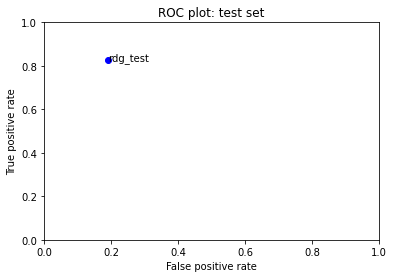

In [159]:
fits = [rdg_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [93]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/home/ec2-user/data/moviereviews_test.tsv', my_random_seed=55, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

FileNotFoundError: [Errno 2] No such file or directory: '/home/ec2-user/data/moviereviews_test.tsv'

---

# <span style="color:red">SUBMISSION</span>

---

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [ ]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

In [ ]:
raw_data.head()

In [ ]:
my_submission.head()

In [ ]:
my_submission.shape

In [ ]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/home/ec2-user/data/moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation